# Data analysis


This notebook provides the code for generating the visualizations for the manuscript "Elite Political Discourse has Become More Toxic in Western Countries".

In [3]:
import pandas as pd

### 1. Global average over time 

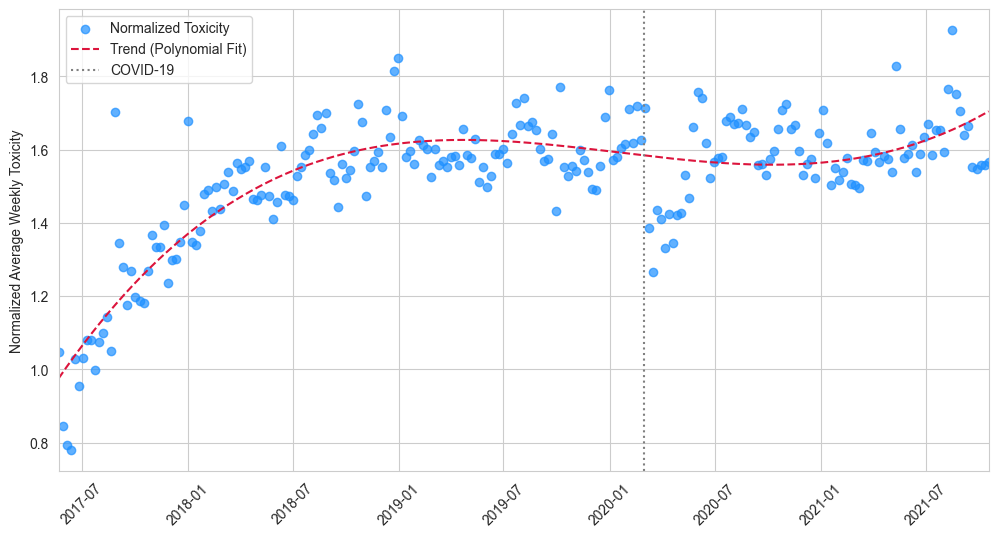

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'created_at' to datetime and extract year-week
m['created_at'] = pd.to_datetime(m['created_at'])
m['year_week'] = m['created_at'].dt.to_period('W')

# Compute mean toxicity per party per week
party_week_toxicity = mm.groupby(['year_week', 'partyid'])['toxicity'].agg(['mean', 'count']).reset_index()

# Filter out party-weeks with fewer than 100 rows
party_week_toxicity = party_week_toxicity[party_week_toxicity['count'] >= 100]

# Compute the mean of means per week
avg_toxicity = party_week_toxicity.groupby('year_week')['mean'].mean().reset_index()

# Convert period to datetime
avg_toxicity['year_week'] = avg_toxicity['year_week'].astype(str)
avg_toxicity['year_week'] = pd.to_datetime(avg_toxicity['year_week'].apply(lambda x: x.split('/')[0]))

# Use the first 3 months as the baseline (you can tweak this range)
start_period = avg_toxicity['year_week'].min()
end_period = start_period + pd.DateOffset(months=3)
baseline = avg_toxicity.loc[avg_toxicity['year_week'] < end_period, 'mean'].mean()

# Normalize
avg_toxicity['normalized_mean'] = avg_toxicity['mean'] / baseline

# Prepare data for polynomial fit
x = np.arange(len(avg_toxicity))
y = avg_toxicity['normalized_mean']  # Use normalized values now

# Fit a polynomial (degree 3)
poly_coeffs = np.polyfit(x, y, deg=3)
poly_fit = np.poly1d(poly_coeffs)

# Plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

plt.scatter(avg_toxicity['year_week'], y, label="Normalized Toxicity", color="dodgerblue", alpha=0.7)
plt.plot(avg_toxicity['year_week'], poly_fit(x), color="crimson", linestyle="--", label="Trend (Polynomial Fit)")

# Add vertical line for 'COVID-19 impact'
covid_impact_date = pd.to_datetime('2020-03-01')
plt.axvline(covid_impact_date, color='grey', linestyle=':', linewidth=1.5, label='COVID-19')

plt.ylabel("Normalized Average Weekly Toxicity")
plt.legend()
plt.xticks(rotation=45)
plt.xlim([avg_toxicity['year_week'].min(), avg_toxicity['year_week'].max()])

plt.savefig('final/fig1_overtime.png', dpi=300, bbox_inches="tight")
plt.savefig('final/fig1_overtime.pdf', bbox_inches="tight")

plt.show()

### 2. US average by party over time

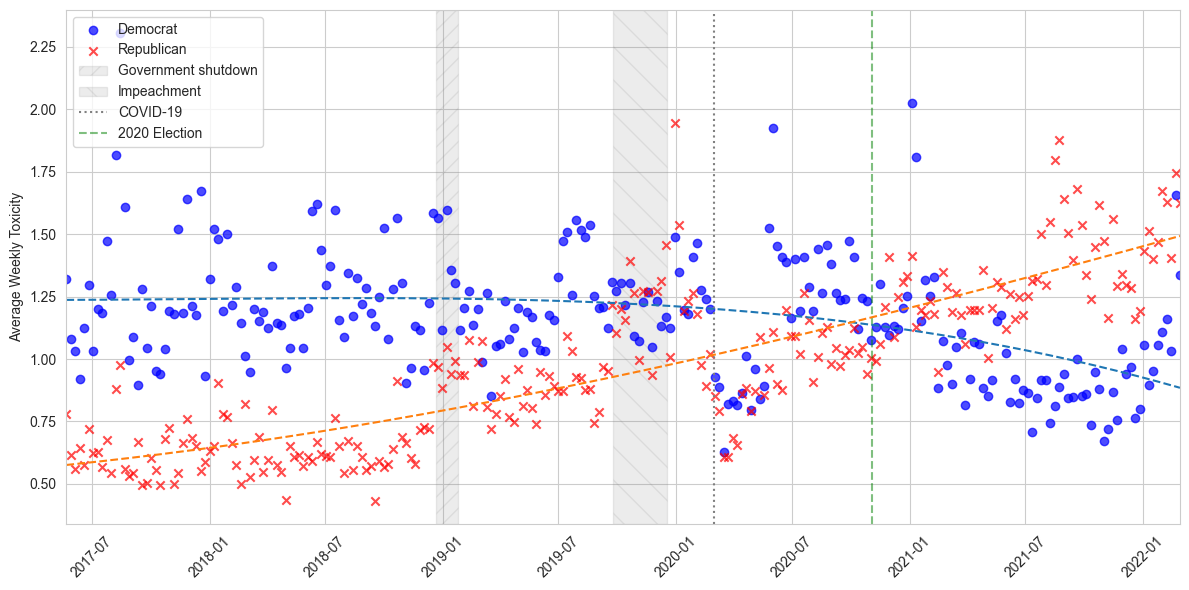

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'created_at' to datetime and extract year-week
m['created_at'] = pd.to_datetime(m['created_at'])
m['year_week'] = m['created_at'].dt.to_period('W')

# Filter for only the United States
mm = m[m['country'] == 'United States']

# Compute average toxicity per week, grouped by party
avg_toxicity = mm.groupby(['party_name', 'year_week'])['toxicity'].mean().reset_index()

# Convert period to datetime for plotting
avg_toxicity['year_week'] = avg_toxicity['year_week'].astype(str)
avg_toxicity['year_week'] = pd.to_datetime(avg_toxicity['year_week'].apply(lambda x: x.split('/')[0]))

# Get unique parties
parties = avg_toxicity['party_name'].unique()

# Determine baseline period: first 3 months in the data
start_date = avg_toxicity['year_week'].min()
end_date = start_date + pd.DateOffset(months=3)

# Compute baseline mean toxicity (across all parties)
baseline = avg_toxicity.loc[avg_toxicity['year_week'] < end_date, 'toxicity'].mean()

# Normalize all toxicity values using this baseline
avg_toxicity['toxicity'] = avg_toxicity['toxicity'] / baseline

# Define colors for parties
party_colors = {
    'Democratic': 'blue',  # Blue for Democrat
    'Republican': 'red'  # Red for Republican
}

sns.set_style("whitegrid")
plt.figure(figsize=(12, 6))

# Add shaded areas for key events
plt.axvspan(pd.to_datetime('2018-12-22'), pd.to_datetime('2019-01-25'), color='gray', hatch='//', alpha=0.15, label="Government shutdown")
plt.axvspan(pd.to_datetime('2019-09-24'), pd.to_datetime('2019-12-18'), color='gray', hatch='\\', alpha=0.15, label="Impeachment")
covid_impact_date = pd.to_datetime('2020-03-01')
plt.axvline(covid_impact_date, color='grey', linestyle=':', linewidth=1.5, label='COVID-19')
covid_impact_date = pd.to_datetime('2020-11-03')
plt.axvline(covid_impact_date, color='green', linestyle='--', alpha=0.5, linewidth=1.5, label='2020 Election')

# Define colors and markers for parties
party_colors = {'Democratic': 'blue', 'Republican': 'red'}
party_markers = {'Democratic': 'o', 'Republican': 'x'}

# Plot the data for each party
for party in parties:
    party_data = avg_toxicity[avg_toxicity['party_name'] == party]
    x = np.arange(len(party_data))
    y = party_data['toxicity']

    # Fit a polynomial (degree 3) if enough data points exist
    if len(y) > 3:
        poly_coeffs = np.polyfit(x, y, deg=3)
        poly_fit = np.poly1d(poly_coeffs)
        plt.plot(party_data['year_week'], poly_fit(x), linestyle="--")

    # Scatter plot of actual data with specific color and marker for each party
    party_color = party_colors.get(party, 'black')  # Default to black if the party isn't in the dictionary
    party_marker = party_markers.get(party, 's')  # Default to square marker if not specified
    plt.scatter(party_data['year_week'], y, label=party, color=party_color, marker=party_marker, alpha=0.7)

# Get the handles and labels, and reorder them
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder the legend so that Democrat and Republican appear first
ordered_labels = ['Democrat', 'Republican'] + [label for label in labels if label not in ['Democratic', 'Republican']]
ordered_handles = [handle for label, handle in zip(labels, handles) if label in ['Democratic', 'Republican']] + [handle for label, handle in zip(labels, handles) if label not in ['Democratic', 'Republican']]

# Add semi-opaque white background to the legend
plt.legend(handles=ordered_handles, labels=ordered_labels, loc="upper left", framealpha=0.8, facecolor='white', frameon=True)

# Formatting
plt.xlabel(None)
plt.ylabel("Average Weekly Toxicity")

# Adjust x-axis limits to remove gaps on the left and right
plt.xlim([avg_toxicity['year_week'].min(), avg_toxicity['year_week'].max()])

# plt.ylim([0.0, 0.11])

plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('final/fig2_US_overtime.png', dpi=300)
plt.savefig('final/fig2_US_overtime.pdf')

plt.show()

## Topics

In [4]:
import pandas as pd 
df = pd.read_pickle('categorizations_of_posts.df.pkl')

In [8]:
# Load topics into the data
df.loc[df['category']==13,'category'] = 12
df = df.loc[(df['category']>0)&(df['category']<=13)]
df_dict = df.set_index('id')['category'].to_dict()
m['category'] = [int(df_dict[str(cid)]) if str(cid) in df_dict else None for cid in m['tweet_id']]
cattotop = {1: 'Economic',2: 'Welfare',3: 'Migration',4: 'Democracy',5: 'Security',6: 'Environment',7: 'Identity', 8: 'Nationalism', 9: 'Technology',10: 'Crime', 11: 'Education', 12: 'Non-Political'}
m['topic'] = [cattotop[c] if c in cattotop else None for c in m['category']]

### Validate topics against manual classification

In [54]:
# Store for manual validation
# m[['tweet_id','text']].sample(300).to_csv('final/validation.csv')

In [21]:
# Load the resulting manual annotations
val = pd.read_csv('final/manualcoding.csv',dtype=str)

In [23]:
# Compare the manual annotations against the LLM annotations
val = val.dropna()
val['tweet_id'] = val['tweet_id'].astype("int64")

# Merge in LLM classification 
val = val.merge(m[['tweet_id', 'topic']], on='tweet_id', how='left')

In [28]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = (val['topic'] == val['topic_manual']).mean()

# Calculate precision, recall, and f1-score
precision = precision_score(val['topic_manual'], val['topic'], average='weighted')
recall = recall_score(val['topic_manual'], val['topic'], average='weighted')
f1 = f1_score(val['topic_manual'], val['topic'], average='weighted')

# Confusion matrix
conf_matrix = confusion_matrix(val['topic_manual'], val['topic'])

# Classification report
class_report = classification_report(val['topic_manual'], val['topic'])

f1_macro = f1_score(val['topic_manual'], val['topic'], average='macro')
recall_macro = recall_score(val['topic_manual'], val['topic'], average='macro')
precision_macro = precision_score(val['topic_manual'], val['topic'], average='macro')
print(f"F1-Score (macro): {f1_macro:.4f}")
print(f"Recall (macro): {recall_macro:.4f}")
print(f"Precision (macro): {precision_macro:.4f}")

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

F1-Score (macro): 0.8480
Recall (macro): 0.8997
Precision (macro): 0.8370
Accuracy: 0.8721
Precision (weighted): 0.8836
Recall (weighted): 0.8721
F1-Score (weighted): 0.8725
Confusion Matrix:
[[17  0  0  0  0  0  0  0  1  0  0  1]
 [ 0 55  2  0  0  0  0  1  3  0  0  1]
 [ 0  0 31  0  0  0  0  0  0  0  1  0]
 [ 1  0  1  4  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 12  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 16  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  9  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0]
 [ 0  8  3  0  0  3  0  2 67  0  0  1]
 [ 0  1  0  0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0]
 [ 2  0  3  0  0  0  0  0  1  0  0 37]]
Classification Report:
              precision    recall  f1-score   support

       Crime       0.85      0.89      0.87        19
   Democracy       0.86      0.89      0.87        62
    Economic       0.78      0.97      0.86        32
   Education       1.00      0.57      0.73         7
 Environment       1.00      1.00      1.00  

### Normalized topics frequency internationally

/var/folders/72/yhvs2cms3j9cxd1ln67f720h0000gn/T/ipykernel_19504/2741883579.py:40: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


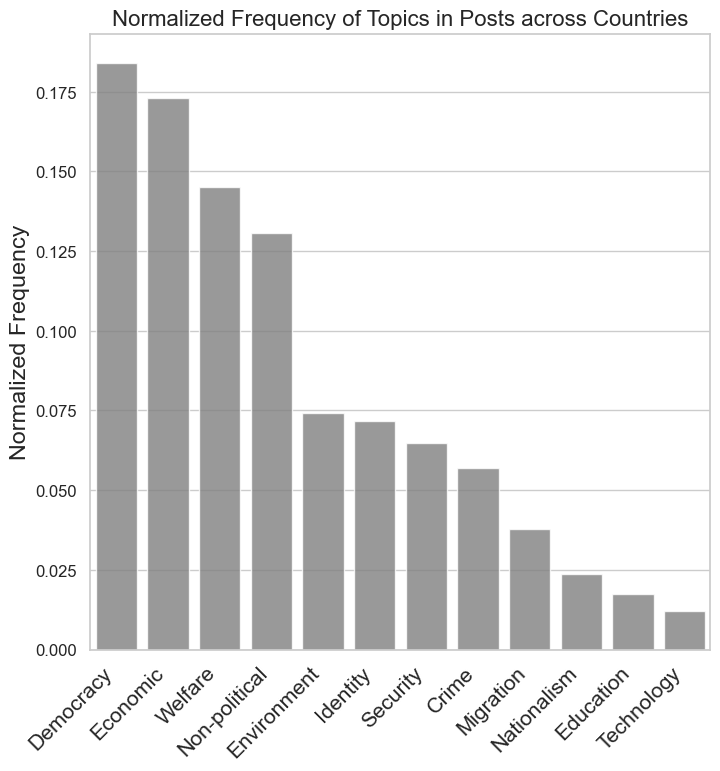

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Seaborn style for academic visualization
sns.set(style="whitegrid", palette="gray", font_scale=1.4)


# Compute tweet distribution
tweets_per_country = m['country'].value_counts().to_dict()

# Compute normalized topic frequencies
topic_distribution = (
    m.groupby(['country', 'topic'])
    .size()
    .reset_index(name='count')
)
topic_distribution['normalized'] = topic_distribution.apply(
    lambda row: row['count'] / tweets_per_country[row['country']], axis=1
)

# Aggregate normalized counts per topic
topic_totals = (
    topic_distribution.groupby('topic')['normalized']
    .sum()
    .sort_values(ascending=False)
)

# Set topic order based on total occurrences
topic_distribution['topic'] = pd.Categorical(
    topic_distribution['topic'], categories=topic_totals.index, ordered=True
)

# Initialize figure
plt.figure(figsize=(8, 8))

# Create bar plot with single color (gray) for consistency
sns.barplot(
    data=topic_distribution,
    x="topic",
    y="normalized",
    order=topic_totals.index,
    ci=None,  # Do not include error bars since it's a full dataset. 
    color="gray",
    alpha=0.8
)


# Customize labels and appearance
plt.xlabel("")
plt.ylabel("Normalized Frequency")
plt.xticks(rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.title("Normalized Frequency of Topics in Posts across Countries", fontsize=16)

# Remove unnecessary spines
# sns.despine()

# Save the figure in both PNG and PDF formats with high resolution
plt.savefig("final/topicfrequency.png", dpi=300, bbox_inches="tight")
plt.savefig("final/topicfrequency.pdf", bbox_inches="tight")

# Show plot
plt.show()

### Frequency of topics by party in the US

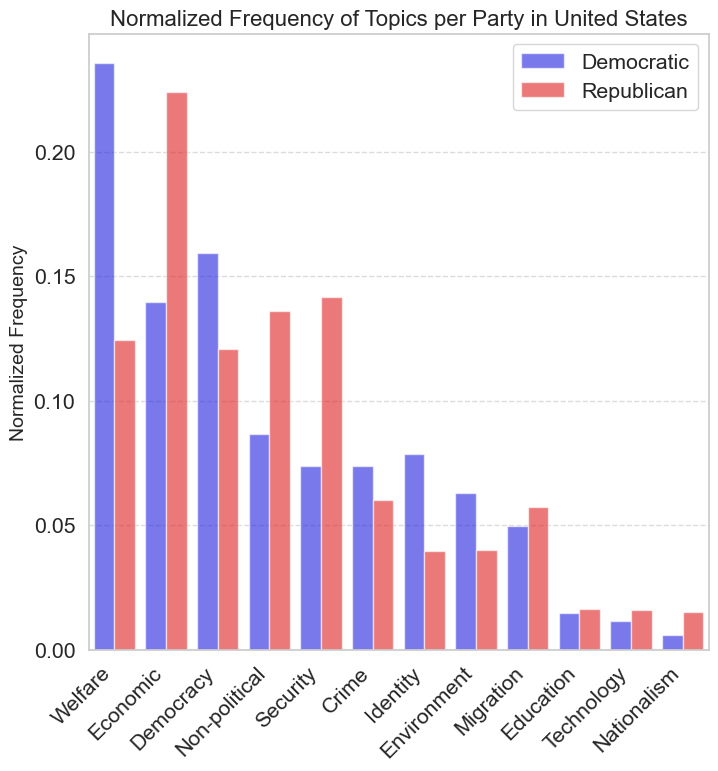

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configure Seaborn for academic visualization
sns.set(style="whitegrid", palette="gray", font_scale=1.4)

# Filter dataset to focus on US parliamentarians
us_data = m.loc[m['country'] == 'United States']

# Compute total tweets per party
tweets_per_party = us_data['party_name'].value_counts().to_dict()

# Compute topic frequency per party and normalize
topic_distribution = (
    us_data.groupby(['party_name', 'topic'])
    .size()
    .reset_index(name='count')
)
topic_distribution['normalized'] = topic_distribution.apply(
    lambda row: row['count'] / tweets_per_party[row['party_name']], axis=1
)

# Aggregate total occurrences of each topic
topic_totals = (
    topic_distribution.groupby('topic')['count']
    .sum()
    .sort_values(ascending=False)
)

# Define topic order for consistency
topic_distribution['topic'] = pd.Categorical(
    topic_distribution['topic'], categories=topic_totals.index, ordered=True
)

# Initialize figure
plt.figure(figsize=(8, 8))

# Define custom color palette for parties
party_palette = {'Democratic': 'blue', 'Republican': 'red'}

# Create bar plot with custom colors for parties
sns.barplot(
    data=topic_distribution,
    x="topic",
    y="normalized",
    hue="party_name",
    dodge=True,
    palette=party_palette,  # Custom color palette for parties
    order=topic_totals.index,
    alpha=0.6
)

plt.legend(title=None)

# Customize labels and title
plt.xlabel("")
plt.ylabel("Normalized Frequency", fontsize=14)
plt.title("Normalized Frequency of Topics per Party in United States", fontsize=16)
plt.xticks(rotation=45, ha="right")  # Improve readability
# plt.yticks(fontsize=12)
# sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Subtle grid for readability

# Save high-resolution figures for publication
plt.savefig("final/topicfrequency_US.png", dpi=300, bbox_inches="tight")
plt.savefig("final/topicfrequency_US.pdf", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

### Global average normalized toxicity of topics

In [ ]:
# Total overall toxicity
# To analyze toxicity by topic while accounting for country variance, you should normalize toxicity within each country before aggregating. This ensures that country-specific differences in toxicity levels do not skew the results. Here’s how you can approach it:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize toxicity within each country
filtered['toxicity_norm'] = filtered.groupby('country')['toxicity'].transform(lambda x: (x - x.mean()) / x.std())

# Aggregate by topic and sort
topic_toxicity = filtered.groupby('topic', as_index=False)['toxicity_norm'].mean()
topic_toxicity = topic_toxicity.sort_values(by='toxicity_norm', ascending=False)

# Plot
plt.figure(figsize=(8, 8))
sns.barplot(data=topic_toxicity, x='topic', y='toxicity_norm', palette='coolwarm_r', order=topic_toxicity['topic'])

# Beautify
plt.xticks(rotation=45, ha='right')
plt.title('Normalized Toxicity by Topic')
plt.ylabel('Mean Normalized Toxicity')
plt.xlabel(None)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig("final/toxic_by_topic.png", dpi=300, bbox_inches="tight")
plt.savefig("final/toxic_by_topic.pdf", dpi=300, bbox_inches="tight")

plt.show()



### US toxicity by party and topic


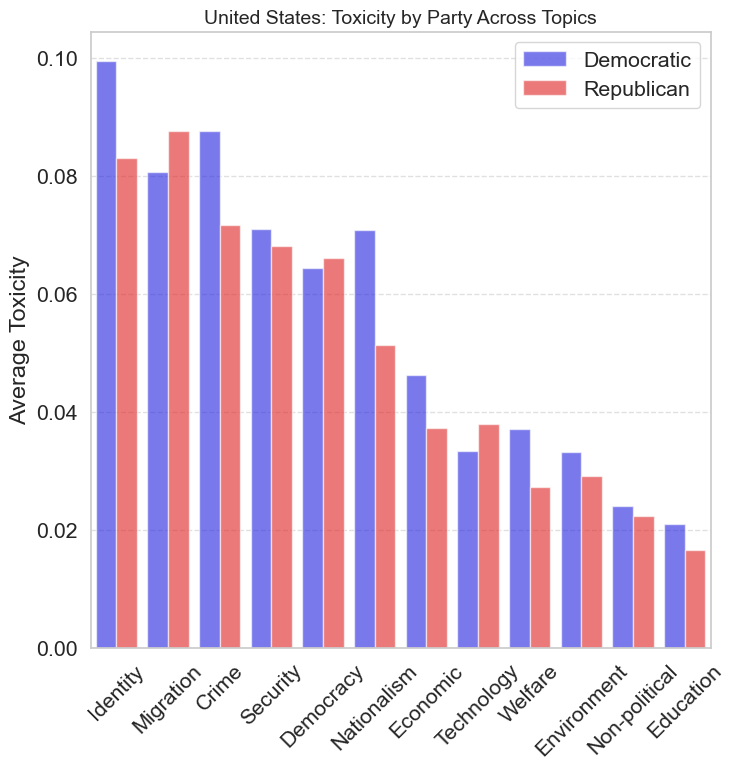

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

mm = m.loc[m['country']=='United States']
mm = mm.loc[mm['topic']!='Other']

# Compute mean toxicity per party and topic
avg_toxicity = mm.groupby(['topic', 'party_name'])['toxicity'].mean().reset_index()

# Compute overall average toxicity per topic (regardless of party)
topic_avg_toxicity = avg_toxicity.groupby('topic')['toxicity'].mean().sort_values(ascending=False)

# Set the topic order based on average toxicity
avg_toxicity['topic'] = pd.Categorical(avg_toxicity['topic'], categories=topic_avg_toxicity.index, ordered=True)

# Define custom color palette for parties
party_palette = {'Democratic': 'blue', 'Republican': 'red'}


# Plot
plt.figure(figsize=(8, 8))
sns.barplot(data=avg_toxicity, x='topic', y='toxicity', hue='party_name', palette=party_palette, order=topic_avg_toxicity.index, alpha=0.6)

plt.legend(title=None)

# Beautify
plt.xlabel(None)
plt.ylabel("Average Toxicity")
plt.title("United States: Toxicity by Party Across Topics", fontsize=14)
plt.xticks(rotation=45)  # Rotate topic labels
# sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.savefig("final/toxic_by_topic_and_party_us.png", dpi=300, bbox_inches="tight")
plt.savefig("final/toxic_by_topic_and_party_us.pdf", dpi=300, bbox_inches="tight")


plt.show()

### 1. Aggregate data for statistical analysis

This code aggregates the data for the statistical analysis. See separate R code.

In [60]:
df = m

In [61]:
# Compute mean toxicity by country
df['country_mean_toxicity'] = df.groupby('country')['toxicity'].transform('mean')

# Flag if toxicity is above the country-specific mean
df['toxicityabovemean'] = (df['toxicity'] > df['country_mean_toxicity']).astype(int)

# Flag if toxicity is above 0.8 (global threshold)
df['toxicityabove08'] = (df['toxicity'] > 0.8).astype(int)

# Compute country-specific quintile thresholds and assign quintile flags
for q, col_name in zip([0.5, 0.7, 0.8, 0.9], 
                       ['toxicity50quintile', 'toxicity70quintile', 
                        'toxicity80quintile', 'toxicity90quintile']):
    df[col_name] = df.groupby('country')['toxicity'].transform(lambda x: (x >= x.quantile(q)).astype(int))

In [62]:
df = df.rename(columns={    
    'party_vd_v2paenname':'party_name',
    'party_vd_v2paind':'vd_party_personalization', 
    'party_vd_v2xpa_popul':'vd_party_populism',
    'party_vd_v2pariglef':'vd_party_leftright',
    'party_vd_v2padisa':'vd_internal_cohesion',
    'party_mf_parfam':'mf_party_family',
    'party_vd_v2papariah':'vd_party_pariah',
    'party_vd_ep_antielite_salience':'vd_party_antielite_saliency',
    'party_vd_ep_v9_popul_saliency':'vd_party_populist_saliency'
})

In [63]:
# Ensure created_at is in datetime format
df['created_at'] = pd.to_datetime(df['created_at'])

# Get unique sorted months
unique_months = sorted(df['created_at'].dt.to_period('M').unique())

# Create a mapping from month to its relative position
month_mapping = {month: i+1 for i, month in enumerate(unique_months)}

# Assign each row its corresponding month number
df['month_number'] = df['created_at'].dt.to_period('M').map(month_mapping)

In [64]:
# Aggregate data on party 

gro = df.groupby(['partyid','month_number']).agg(
    country = ('country', 'first'), 
    partyname = ('party_name', 'first'),        
    total_number_tweets = ('tweet_id', 'count'), 

    toxicity50quintile = ('toxicity50quintile','mean'),
    toxicity70quintile = ('toxicity70quintile','mean'),
    toxicity80quintile = ('toxicity80quintile','mean'),
    toxicity90quintile = ('toxicity90quintile','mean'),
    
    toxicity_mean = ('toxicity','mean'),
    toxicity_var = ('toxicity','var'),
    
    # gender = ('gender', 'first'),     
    
    parlgovid = ('parlgovid', 'first'),     
    manifestoid = ('manifestoid', 'first'),

    # We aggregate the booleans by identifying if they are true for a majority of the rows of the period.
    is_election=('is_election', lambda x: int(x.mean() > 0.5)),
    during_covid_chock=('during_covid_chock', lambda x: int(x.mean() > 0.5)),
    after_covid=('after_covid', lambda x: int(x.mean() > 0.5)),

    vd_party_personalization = ('vd_party_personalization',  'first'),
    vd_party_populism = ('vd_party_populism', 'first'),
    vd_party_leftright = ('vd_party_leftright', 'first'),
    vd_internal_cohesion = ('vd_internal_cohesion', 'first'),    
    mf_party_family = ('mf_party_family', 'first'),
    party_vd_v2papariah = ('vd_party_pariah', 'first'),
    vd_party_antielite_saliency = ('vd_party_antielite_saliency', 'first'),
    vd_party_populist_saliency = ('vd_party_populist_saliency', 'first'),

    # Is it in cabinet during a majority of rows in the month?
    is_in_cabinet = ('cabinet_cabinet_party',lambda x: int(x.mean() > 0.5))
        
)

In [52]:
# Store data, filter on at least 10 tweets.
gro.loc[gro['total_number_tweets']>10].to_stata('./data.dta', version=118)  


## Supplementary Material

### Country by country average over time

In [ ]:
# Show plots by individual countries over time of the average toxicity per month

Belgium


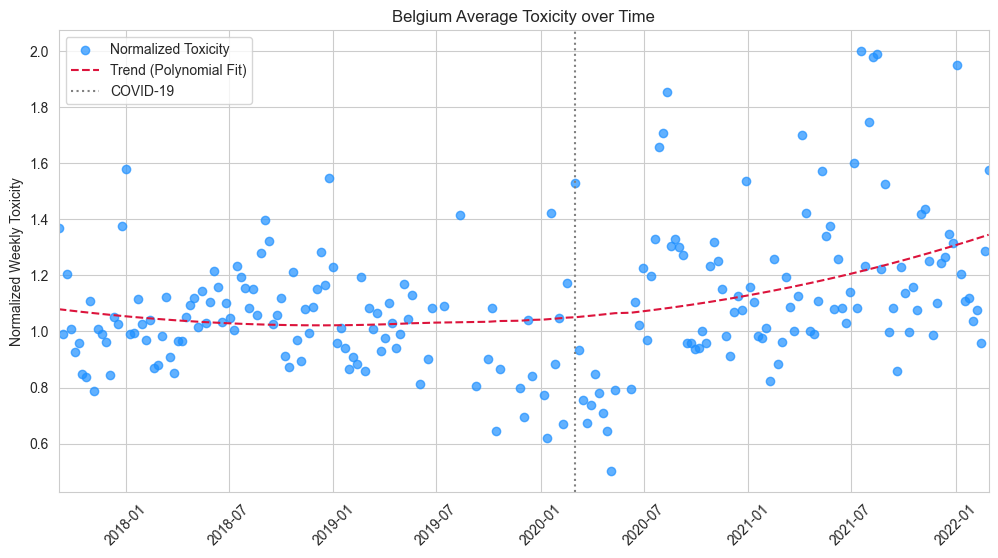

France


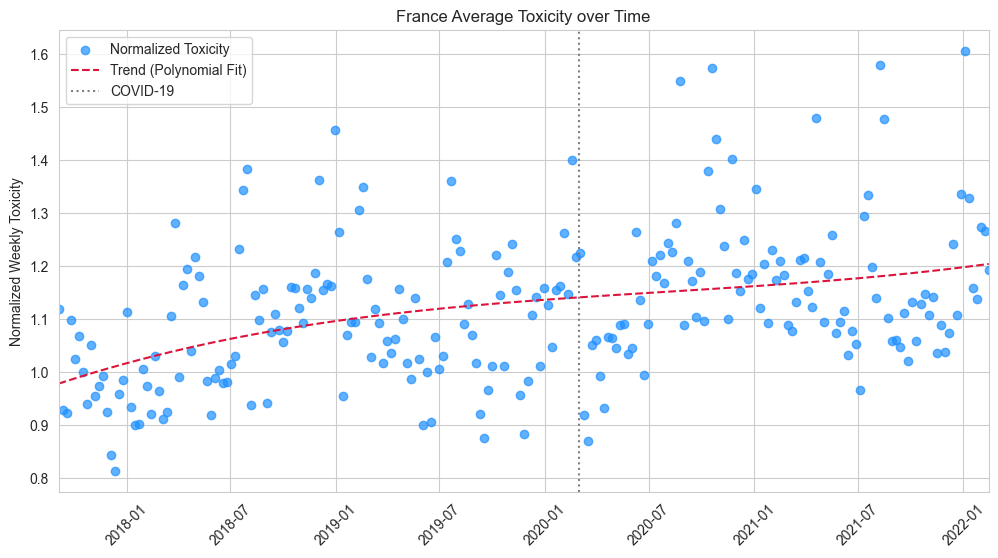

Canada


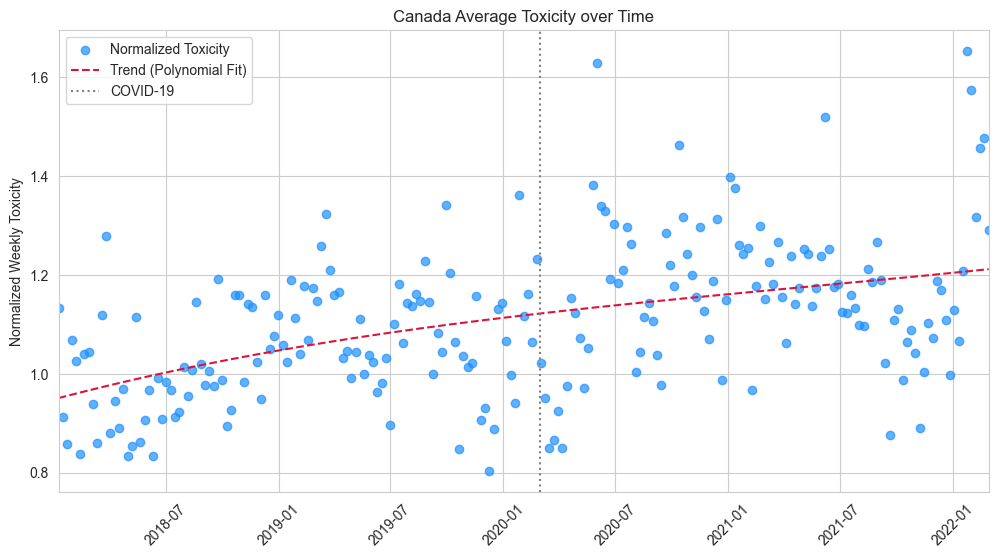

Spain


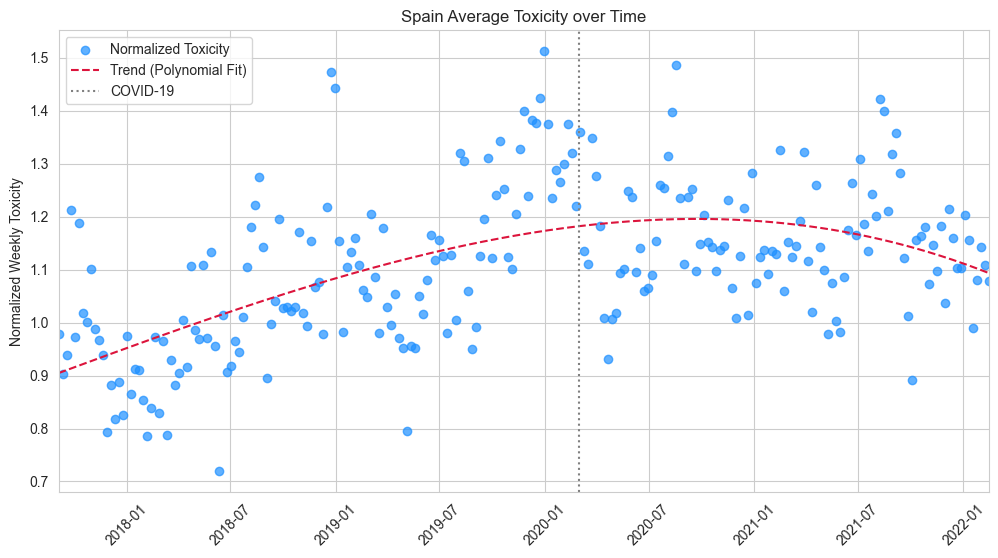

United States


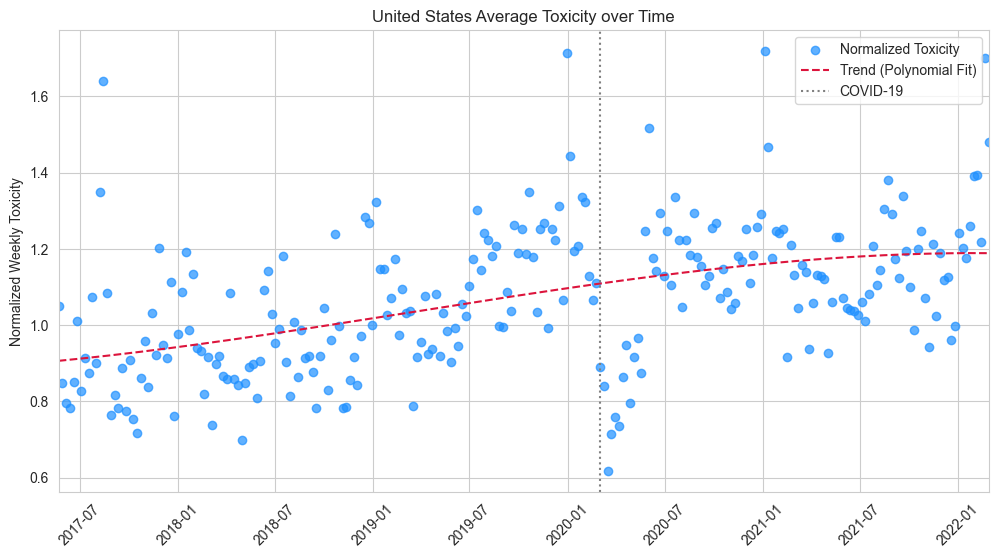

United Kingdom


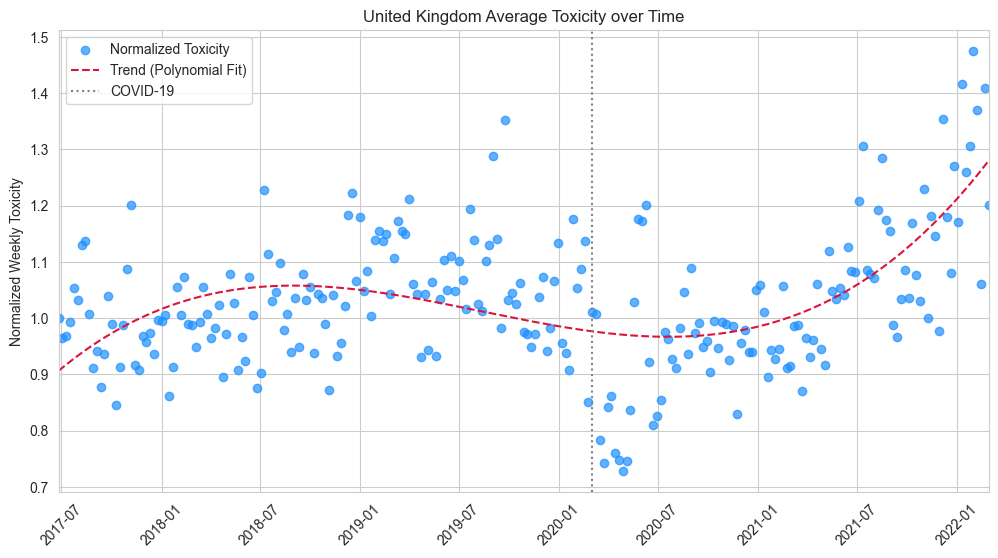

Australia


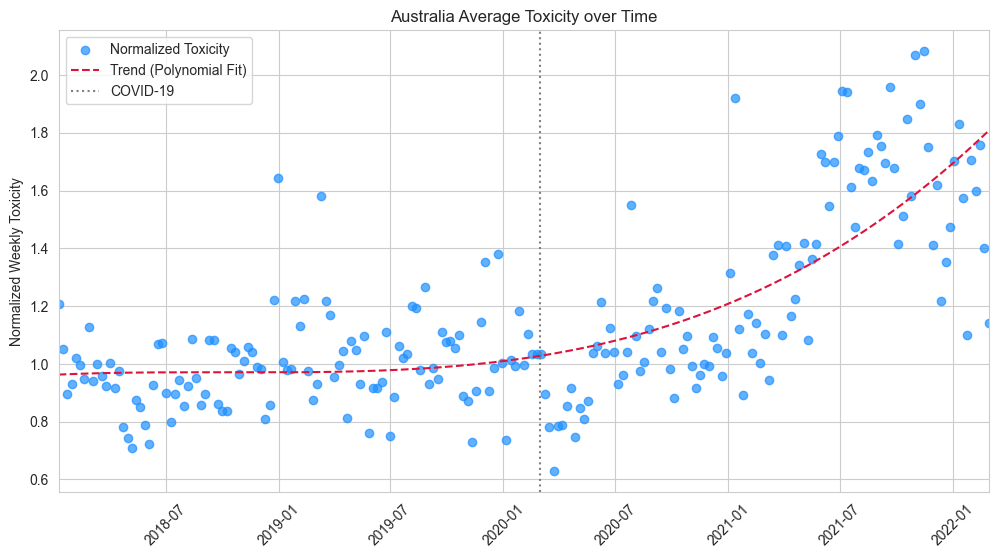

Ireland


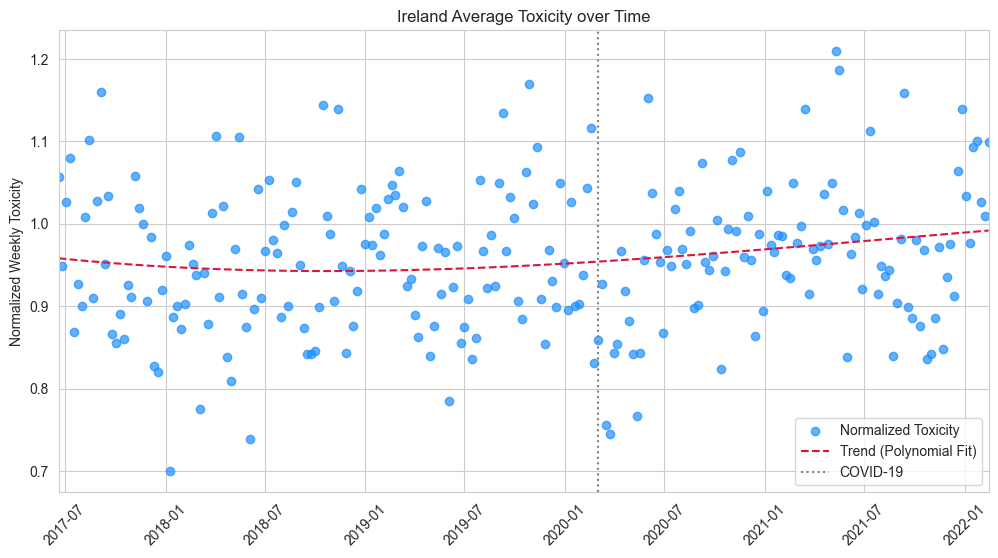

Italy


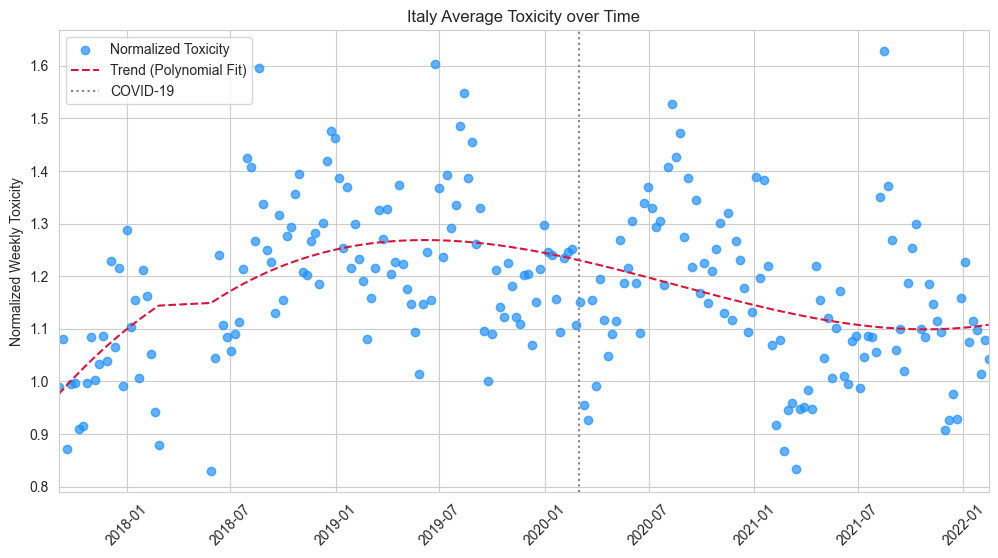

Germany


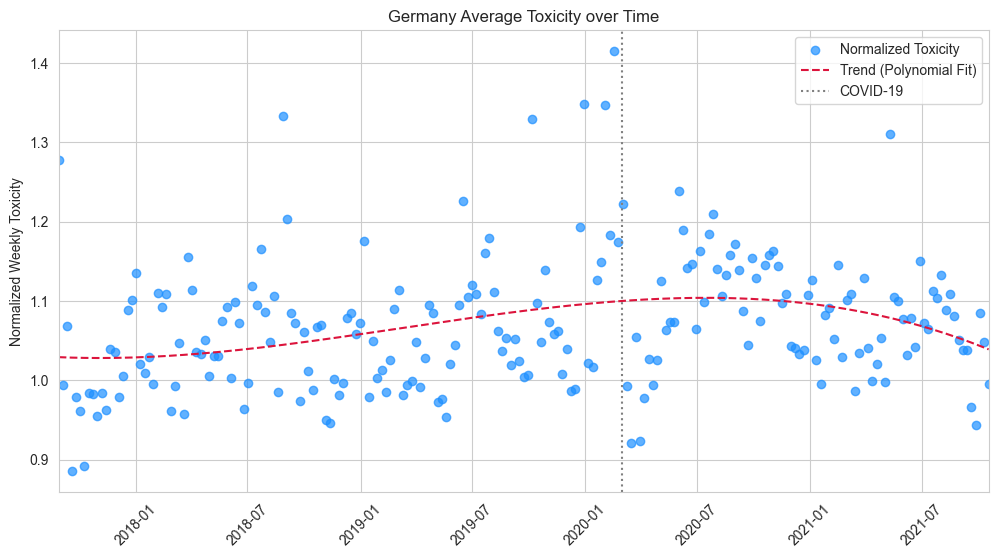

Switzerland


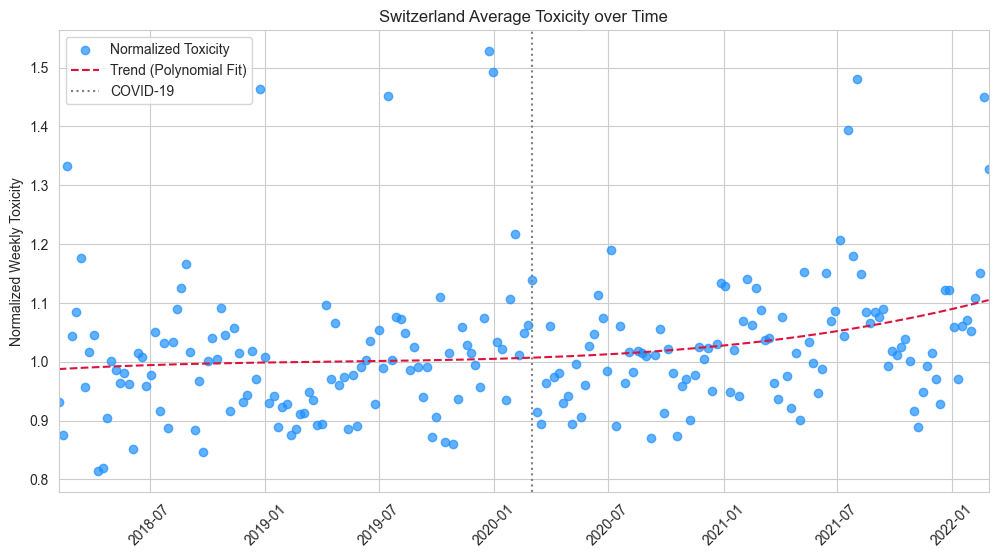

Austria


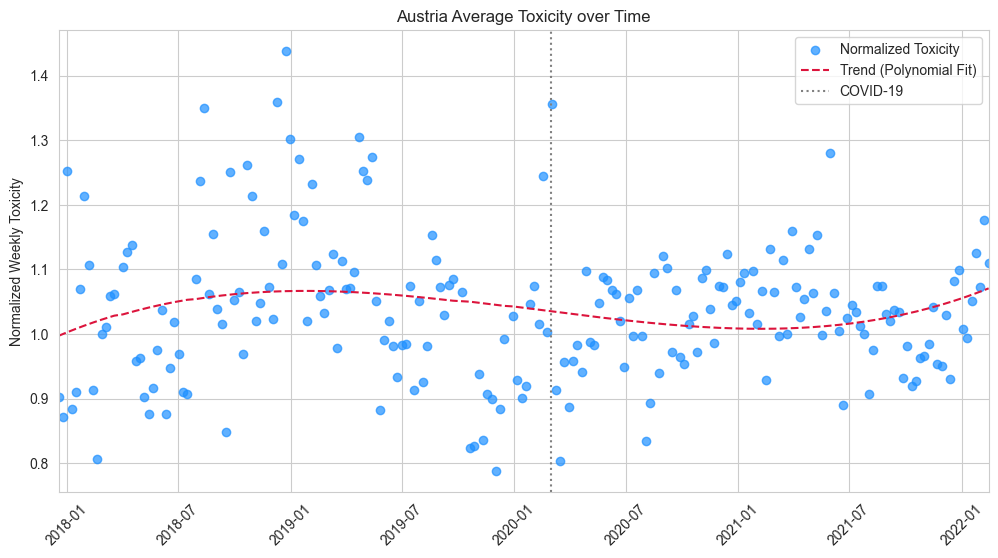

Netherlands


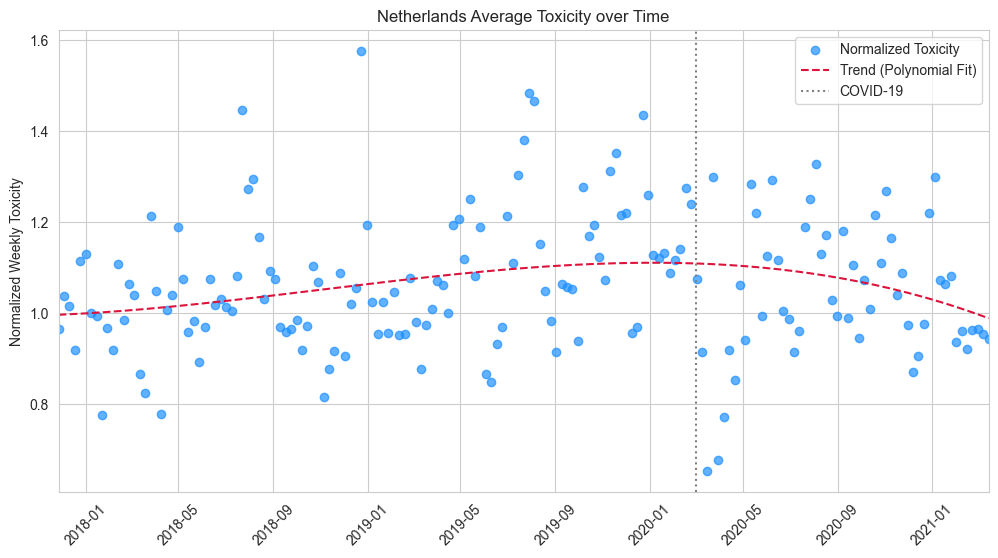

New Zealand


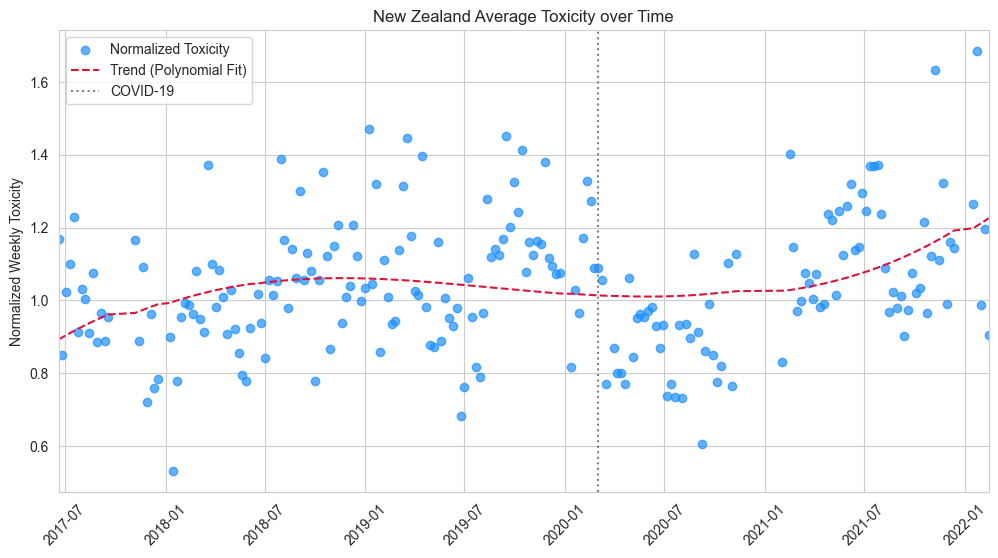

Poland


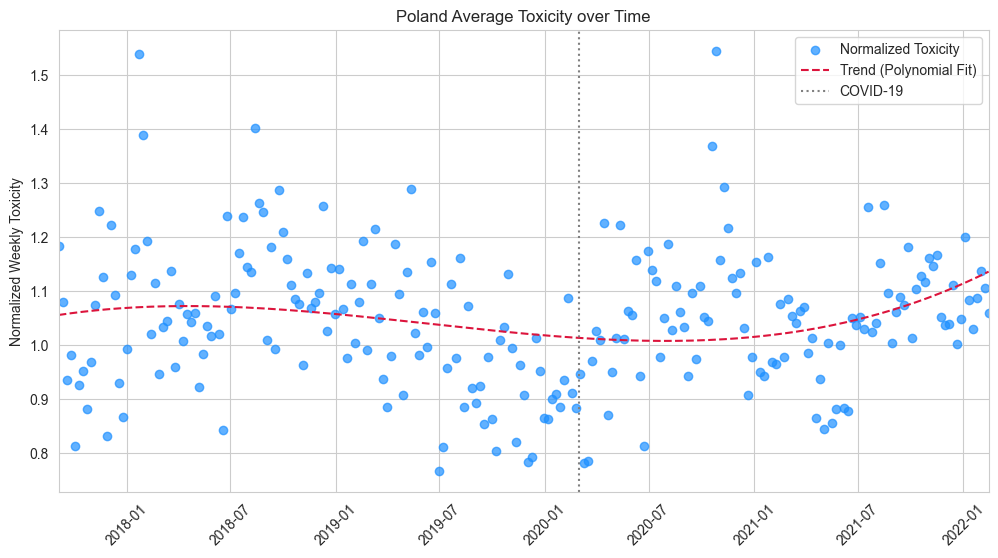

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def plot_country_over_time(country):

    m['year_week'] = m['created_at'].dt.to_period('W')
    mm = m.loc[m['country']==country]

    # Compute mean toxicity per party per week
    party_week_toxicity = mm.groupby(['year_week', 'partyid'])['toxicity'].agg(['mean', 'count']).reset_index()

    # Filter out party-weeks with fewer than 100 rows
    party_week_toxicity = party_week_toxicity[party_week_toxicity['count'] >= 100]

    # Compute the mean of means per week
    avg_toxicity = party_week_toxicity.groupby('year_week')['mean'].mean().reset_index()

    # Convert period to datetime for plotting
    avg_toxicity['year_week'] = avg_toxicity['year_week'].astype(str)
    avg_toxicity['year_week'] = pd.to_datetime(avg_toxicity['year_week'].apply(lambda x: x.split('/')[0]))

    # Compute normalization baseline: mean of first 3 months
    start_date = avg_toxicity['year_week'].min()
    end_date = start_date + pd.DateOffset(months=3)
    baseline = avg_toxicity.loc[avg_toxicity['year_week'] < end_date, 'mean'].mean()

    # Normalize
    avg_toxicity['normalized_mean'] = avg_toxicity['mean'] / baseline

    # Prepare data for polynomial fit
    x = np.arange(len(avg_toxicity))
    y = avg_toxicity['normalized_mean']

    # Fit a polynomial (degree 3)
    poly_coeffs = np.polyfit(x, y, deg=3)
    poly_fit = np.poly1d(poly_coeffs)

    # Plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))

    plt.scatter(avg_toxicity['year_week'], y, label="Normalized Toxicity", color="dodgerblue", alpha=0.7)
    plt.plot(avg_toxicity['year_week'], poly_fit(x), color="crimson", linestyle="--", label="Trend (Polynomial Fit)")

    # Add vertical line for 'COVID-19 impact' on 2023-03-01
    covid_impact_date = pd.to_datetime('2020-03-01')
    plt.axvline(covid_impact_date, color='grey', linestyle=':', linewidth=1.5, label='COVID-19')

    # plt.title("Global Average Weekly Toxicity")
    # Formatting
    plt.title(f'{country} Average Toxicity over Time')
    plt.xlabel(None)
    plt.ylabel("Normalized Weekly Toxicity")
    plt.legend()
    plt.xticks(rotation=45)

    # Adjust x-axis limits to remove gaps on the left and right
    plt.xlim([avg_toxicity['year_week'].min(), avg_toxicity['year_week'].max()])

    plt.savefig(f'final/si_2_overtime_{country}.png', dpi=300,bbox_inches="tight")
    plt.savefig(f'final/si_2_overtime_{country}.png',bbox_inches="tight")

    plt.show()


for country in m.country.unique():    
    print(country)
    plot_country_over_time(country)



### Average normalized toxicity by country

In [ ]:

import pandas as pd

# Step 1: Normalize toxicity within each country
m['toxicity_normalized'] = m.groupby('country')['toxicity'].transform(
    lambda x: (x - x.mean()) / x.std(ddof=0)
)

# Step 2: Count number of rows per country-party
counts = m.groupby(['country', 'party_name']).size().reset_index(name='count')

# Step 3: Filter out country-party combinations with fewer than 500 rows
valid_combinations = counts[counts['count'] >= 500][['country', 'party_name']]

# Step 4: Merge to keep only valid combinations
filtered = pd.merge(m, valid_combinations, on=['country', 'party_name'])

# Step 5: Compute average normalized toxicity by country-party
avg_toxicity_by_party = (
    filtered.groupby(['country', 'party_name'])['toxicity_normalized']
    .mean()
    .reset_index()
    .rename(columns={'toxicity_normalized': 'avg_normalized_toxicity'})
)

# Step 6: Create one table per country
country_tables = {
    country: df.drop(columns='country').reset_index(drop=True)
    for country, df in avg_toxicity_by_party.groupby('country')
}